## Introduction

In this project, I've used various python tools and jupyter notebook to work on evaluating price of houses given the following features:

1. Year of sale of the house
2. The age of the house at the time of sale
3. Distance from city center
4. Number of stores in the locality
5. The latitude
6. The longitude


First step is to import all the required libraries and utility functions.

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

%matplotlib inline
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

print('Libraries are imported.')

Libraries are imported.


## Importing Data

The dataset is saved in a `data.csv` file.

In [96]:
df = pd.read_csv('data.csv', names = column_names) #Importing csv file data.csv and storing the data in 'df'
df.head() #Displaying the table

,serial,date,age,distance,stores,latitude,longitude,price
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


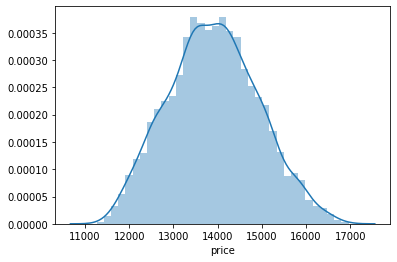

In [97]:
sns.distplot(df['price'])

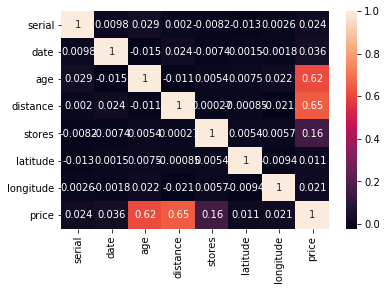

In [98]:
sns.heatmap(df.corr(),annot = True) #Just to see the correlation between the features and the label

## Checking For Missing Data


In [99]:
df.isna().sum() # isna() gives true or false value (1/0) if the data in the column is missing or present respectively
                # sum() then counts the total missing fields in all columns

serial       0
date         0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64

## Data Normalization

Data is normalized so as to bring all the different features to a similar range, thus to make it easier for optimization algorithms to find minimas.

In [100]:
df = df.iloc[:,1:] 
df_norm = (df - df.mean()) / df.std() #Data is normalized by subtracting each value in the column with the mean value and then dividing it with the standard                                                 deviation of the whole column
df_norm.head()

,date,age,distance,stores,latitude,longitude,price
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


Convert Label Value Back To Original:

The Labelvalues are normalized, thus we'll get predictions from the trained model in the same range and are required to be original range. 

In [101]:
y_mean = df['price'].mean()
y_std = df['price'].std()

def convert_label_value(pred):       #Defining a function which will convert the label values back to the original distribution and return it
    return int(pred * y_std + y_mean)


## Creating Training and Test Sets

Select Features:

First we'll remove the last 'price' column and select all other columns as the feature.(Last column is the label)

In [102]:
X = df_norm.iloc[:, :6] #Storing the features in 'X'
X.head()

,date,age,distance,stores,latitude,longitude
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141


Select Labels:

Now we'll select and store the last column as the Labels.

In [103]:
Y = df_norm.iloc[:, -1] #Storing the labels in 'Y'
Y.head()

0    0.350088
1   -1.836486
2   -0.339584
3   -1.839425
4    0.245266
Name: price, dtype: float64

Feature and Label Values:

We will now just extract the numeric values for the features and labels.

In [104]:
X_arr = X.values
Y_arr = Y.values

print('X_arr shape: ', X_arr.shape) #'shape' gives the dimension of the entity
print('Y_arr shape: ', Y_arr.shape)

X_arr shape:  (5000, 6)
Y_arr shape:  (5000,)


Train and Test Split:

We will keep some part of the data aside as a test set. The model will not use this set during training and it will be used only for checking the performance of the model in trained and un-trained states.

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X_arr, Y_arr, test_size = 0.05, shuffle = True, random_state=0) 
#This predefined function splits the dataset to train and test set, where test size is given in 'test_size'(Here 5%) 
#Random state ensures that the splits that you generate are reproducible. Scikit-learn uses random permutations to generate the splits.

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (4750, 6)
y_train shape:  (4750,)
X_test shape:  (250, 6)
y_test shape:  (250,)


## Creating the Model

Defining the Model:

Here a function is defined that returns an untrained neural network model of a certain architecture. Here I've created a model with 2 hidden layers.

Input layer consists of 10 neurons (10*(6+1) = 70 weights/parameters), hidden layers consists of 20 (20*(10+1)=220 weights/parameters) and 5 (5*(20+1)=105 weights/parameters) neurons respectively (Extra 1 Input to neurons is the biased unit).

A neural network without an activation function is essentially just a linear regression model. The activation function does the non-linear transformation to the input making it capable to learn and perform more complex tasks. Since it is a regression problem 'relu' (Rectified linear unit) is used.

In [106]:
def get_model():
    
    model = Sequential([
        Dense(10, input_shape = (6,), activation = 'relu'), #10 neurons, Input Layer
        Dense(20, activation = 'relu'),                     #20 neurons, Hidden Layer
        Dense(5, activation = 'relu'),                      #5  neurons, Hidden Layer
        Dense(1)                                            #Output Layer
    ])                                                      #'relu' activation

    model.compile(
        loss='mse',                                         #Trained using Mean square error loss (Cost function) 
        optimizer='adam'                                    #Optimizer used is 'adam' (One of the Fastest optimizers)
    )
    
    return model

model = get_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 10)                70        
_________________________________________________________________
dense_33 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_34 (Dense)             (None, 5)                 105       
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 6         
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


## Model Training

EarlyStopping callback is used from Keras to stop the model training if the validation loss stops decreasing for a few epochs (Here, after 5 epochs).

In [107]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 5) #Defining early stopping parameter (optional, to save time)

model = get_model()

preds_on_untrained = model.predict(X_test) #Make predictions on the test set before training the parameters

#Finally training the model-->
history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 100,
    callbacks = [early_stopping]
)

Epoch 1/100
149/149 [==============================] - 1s 4ms/step - loss: 0.6764 - val_loss: 0.2368
Epoch 2/100
149/149 [==============================] - 1s 4ms/step - loss: 0.2288 - val_loss: 0.1617
Epoch 3/100
149/149 [==============================] - 1s 4ms/step - loss: 0.1810 - val_loss: 0.1560
Epoch 4/100
149/149 [==============================] - 0s 3ms/step - loss: 0.1711 - val_loss: 0.1537
Epoch 5/100
149/149 [==============================] - 0s 3ms/step - loss: 0.1654 - val_loss: 0.1508
Epoch 6/100
149/149 [==============================] - 0s 3ms/step - loss: 0.1627 - val_loss: 0.1552
Epoch 7/100
149/149 [==============================] - 0s 2ms/step - loss: 0.1611 - val_loss: 0.1535
Epoch 8/100
149/149 [==============================] - 0s 3ms/step - loss: 0.1592 - val_loss: 0.1528
Epoch 9/100
149/149 [==============================] - 0s 2ms/step - loss: 0.1587 - val_loss: 0.1492
Epoch 10/100
149/149 [==============================] - 1s 4ms/step - loss: 0.1579 - val_lo

Plotting Training and Validation Loss:

The 'plot_loss' helper function is used to take a look training and validation loss.

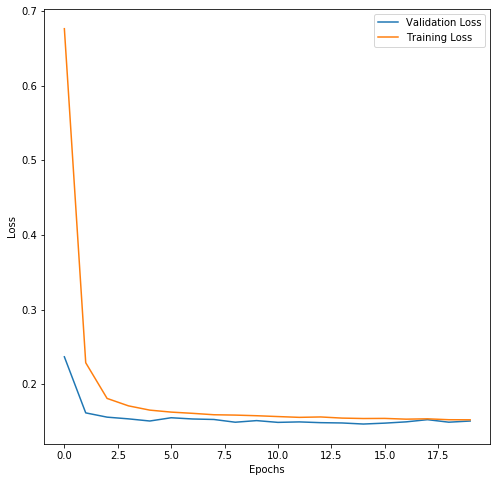

In [108]:
plot_loss(history)

## Final Predictions

Plotting Raw Predictions:

The 'compare_predictions' helper function is used to compare predictions made from the trained and the untrained model.

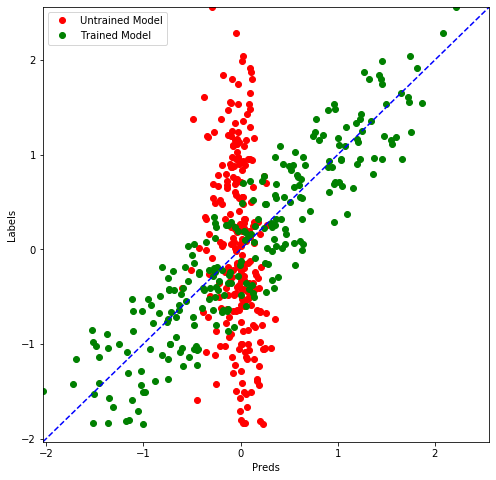

In [109]:
preds_on_trained = model.predict(X_test)

compare_predictions(preds_on_untrained, preds_on_trained, y_test)

Plot Price Predictions:

The raw predictions are converted to price predictions using 'convert_label_value' defined earlier.
The plot for price predictions and raw predictions will look the same with just one difference: The x and y axis scale is changed.

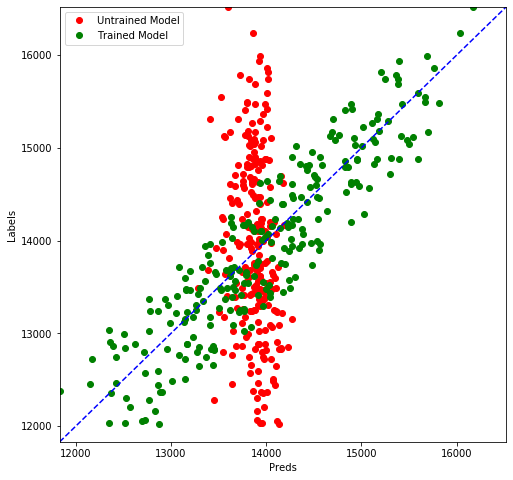

In [110]:
price_on_untrained = [convert_label_value(y) for y in preds_on_untrained]
price_on_trained = [convert_label_value(y) for y in preds_on_trained]
price_y_test = [convert_label_value(y) for y in y_test]

compare_predictions(price_on_untrained, price_on_trained, price_y_test)